# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Homework 6: Trees, Bagging, Random Forests, and Boosting


**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader and Chris Tanner

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

</span></div><div class='alert alert-block alert-danger'><b>WARNING!:</b><span style = 'color:black'> Do not delete any of the `### cs109Test() ###` comment lines!</span></div></div>

</span></div><div class='alert alert-block alert-danger'><b>Note:</b><span style = 'color:black'> Make sure your submission passes all assert statements we've provided in this notebook.</span></div></div>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

# Higgs Boson Discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. 

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background).

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: [Baldi et al., Nature Communications 5, 2014](https://www.nature.com/articles/ncomms5308).

In [3]:
# Load data
data_train = pd.read_csv('data/Higgs_train.csv')
data_test = pd.read_csv('data/Higgs_test.csv')

print(f"{len(data_train)} training samples, {len(data_test)} test samples")
print("\nColumns:")
print(', '.join(data_train.columns))

5000 training samples, 5000 test samples

Columns:
lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb, class


In [4]:
display(data_train.head())
display(data_train.describe())

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080,1.0
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938,1.0
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917,1.0
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954,1.0
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957,0.0


,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.978645,-0.014280,-0.018956,1.005793,0.002528,0.980390,0.025014,-0.007104,0.993678,0.988659,-0.010310,-0.006926,1.006922,0.997004,0.018817,0.003952,1.011994,0.982806,0.005201,0.003349,1.007810,1.038431,1.027201,1.054719,1.023094,0.958464,1.033432,0.960494,0.524600
std,0.547025,1.011927,0.997945,0.591907,1.003337,0.463677,1.002018,1.014559,1.028920,0.476462,1.007983,1.002177,1.045206,0.471681,1.007824,0.999656,1.200416,0.497681,1.007999,1.008904,1.400846,0.619460,0.353984,0.173243,0.427141,0.495720,0.352966,0.306057,0.499444
min,0.275000,-2.410000,-1.740000,0.010000,-1.740000,0.170000,-2.920000,-1.740000,0.000000,0.198000,-2.910000,-1.740000,0.000000,0.265000,-2.720000,-1.740000,0.000000,0.366000,-2.500000,-1.740000,0.000000,0.151000,0.443000,0.339000,0.371000,0.079500,0.413000,0.452000,0.000000
25%,0.587000,-0.764250,-0.877500,0.581000,-0.870000,0.676000,-0.659250,-0.885000,0.000000,0.666000,-0.699000,-0.859500,0.000000,0.664750,-0.679250,-0.858000,0.000000,0.619000,-0.707250,-0.869250,0.000000,0.798750,0.850000,0.986000,0.768000,0.672000,0.826000,0.772750,0.000000
50%,0.846000,-0.009305,-0.016050,0.903500,0.001300,0.891000,0.049500,-0.023500,1.090000,0.891000,-0.004800,-0.030700,1.110000,0.899500,0.045700,0.018800,0.000000,0.877000,0.012900,-0.004700,0.000000,0.898000,0.957000,0.990000,0.922000,0.868000,0.952000,0.877500,1.000000
75%,1.220000,0.725500,0.837000,1.300000,0.866000,1.160000,0.716000,0.894000,2.170000,1.192500,0.692250,0.855500,2.210000,1.232500,0.717000,0.855000,2.550000,1.220000,0.719000,0.859000,3.100000,1.030000,1.090000,1.030000,1.160000,1.120000,1.140000,1.060000,1.000000
max,5.330000,2.430000,1.740000,6.260000,1.740000,4.190000,2.960000,1.740000,2.170000,4.800000,2.910000,1.740000,2.210000,4.630000,2.730000,1.740000,2.550000,5.770000,2.490000,1.740000,3.100000,10.600000,5.740000,3.940000,6.220000,5.080000,4.320000,3.500000,1.000000


In [5]:
# Split into NumPy arrays
X_train = data_train.iloc[:, data_train.columns != 'class'].values
y_train = data_train['class'].values
X_test = data_test.iloc[:, data_test.columns != 'class'].values
y_test = data_test['class'].values

<div class='exercise'><b>Question 1 [20pts]: A Single Model </b></div>
We start by fitting a basic model we can compare the other models to. We will pick a decision tree as the base model because we will later include bagging, random forests and boosting and want a fair comparison. We will tune the decision tree using cross-validation (of course). We will be tuning the maximum tree depth; we refer to this parameter as "depth" for simplicity.

Since we will only be using tree-based methods in this homework, we do not need to standardize or normalize the predictors.


**1.1** Fit a decision tree model to the training set. Choose a range of tree depths from 1 to 20 and evaluate the  performance and standard deviations for each depth using 5-fold cross-validation. Plot the estimated mean +/- 2 standard deviations for each depth. Also, include the training set performance in your plot, but set the y-axis to focus on the cross-validation performance. 
Store the CV means and std variables `cvmeans`, `cvstds` and the train score `train_scores`  

*Hint*: use `plt.fill_between` to shade the region.

**1.2** Select an appropriate depth and justify your choice using your cross-validation estimates. Then report the classification accuracy on the **test set**. Store the training and test accuracies in variables named `best_cv_tree_train_score` and `best_cv_tree_test_score` to refer to in a later question.

**1.3** What is the mechanism by which limiting the depth of the tree avoids over-fitting? What is one downside of limiting the tree depth? 

## Answers

**1.1** Fit a decision tree model to the training set. Choose a range of tree depths from 1 to 20 and evaluate the  performance and standard deviations for each depth using 5-fold cross-validation. Plot the estimated mean +/- 2 standard deviations for each depth. Also, include the training set performance in your plot, but set the y-axis to focus on the cross-validation performance.
Store the CV means and std variables `cvmeans`, `cvstds` and the train score `train_scores`

*Hint*: use `plt.fill_between` to shade the region.


</span></div><div class='alert alert-block alert-danger'><b>WARNING!:</b><span style = 'color:black'> Do not delete any of the `### cs109Test() ###` comment lines!</span></div></div>

In [6]:
### cs109Test(test_1.1a) ###

depths = list(range(1, 21))

def calc_meanstd(X_train, y_train, depths):
    # your code here
    cvmeans = {}
    cvstds = {}
    train_scores = {}
    for i in depths:
        #Find optimal depth of trees
        model = DecisionTreeClassifier(max_depth=i)
        score = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5, n_jobs=-1)
        cvmeans[i] = score.mean()
        cvstds[i] = score.std()
        train_scores[i] = score
    # end of your code here
    return cvmeans, cvstds, train_scores


</span></div><div class='alert alert-block alert-danger'><b>WARNING!:</b><span style = 'color:black'> Do not delete any of the `### cs109Test() ###` comment lines!</span></div></div>

In [7]:
### cs109Test(test_1.1b) ###
# name the CV means and std variables cvmeans, cvstds and the train score train_scores
cvmeans, cvstds, train_scores = calc_meanstd(X_train, y_train, depths)
# your code here 
x = list(cvmeans.keys())
y = list(cvmeans.values())
stds = np.array([item for item in cvstds.values()])
x,y, stds #print lists to make sure they're good

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [0.5994048768048768,
  0.6214066938066938,
  0.621213095013095,
  0.639408912008912,
  0.6424043114043114,
  0.6342055094055095,
  0.6342063086063086,
  0.6268047014047015,
  0.6186024964024963,
  0.611803688003688,
  0.6144034914034914,
  0.6004016828016827,
  0.6012020788020788,
  0.5962062766062766,
  0.5852062702062703,
  0.5919968763968765,
  0.5921960747960748,
  0.5881998725998726,
  0.5849992695992696,
  0.5855992699992699],
 array([0.01081658, 0.01254164, 0.01811672, 0.0109591 , 0.00859164,
        0.00885871, 0.00971276, 0.00916734, 0.01677618, 0.00635356,
        0.01131201, 0.01007718, 0.01074343, 0.01022461, 0.01205889,
        0.01208795, 0.01030353, 0.01186215, 0.00951883, 0.01275808]))

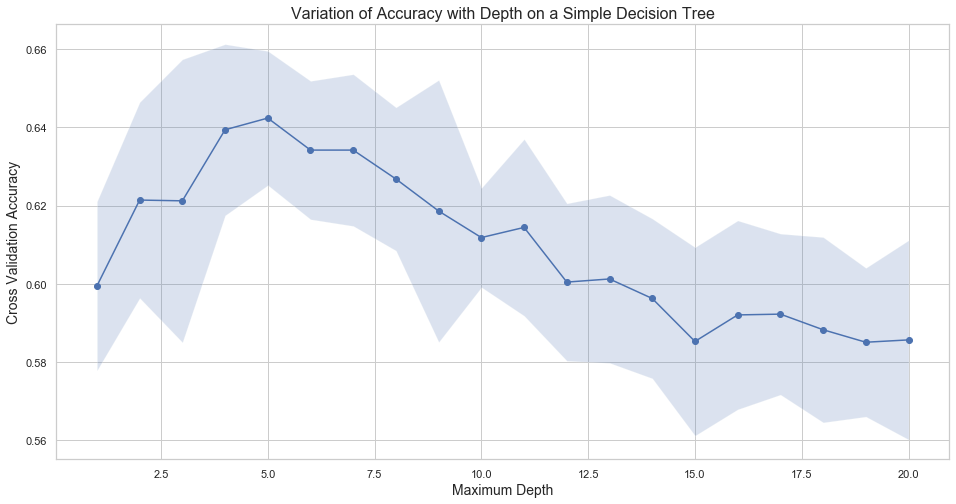

In [8]:
# your code here 
plt.figure(figsize = (16, 8))
plt.fill_between(x, y + 2*stds, y-2*stds, alpha = 0.2)
plt.xlabel("Maximum Depth", fontsize = 14)
plt.ylabel("Cross Validation Accuracy", fontsize = 14)
plt.title("Variation of Accuracy with Depth on a Simple Decision Tree", fontsize = 16)
plt.plot(x, y,  marker = 'o');

</span></div><div class='alert alert-block alert-danger'><b>Note:</b><span style = 'color:black'> Make sure your submission passes all assert statements we've provided in this notebook.</span></div></div>

In [9]:
### 1.1 Check that you have the requested variables
for var in ['train_scores', 'cvmeans', 'cvstds']:
    assert var in globals(), f"Variable '{var}' does not exist!"

**1.2** Select an appropriate depth and justify your choice using your cross-validation estimates. Then report the classification accuracy on the **test set**. Store the training and test accuracies in variables named `best_cv_tree_train_score` and `best_cv_tree_test_score` to refer to in a later question.


</span></div><div class='alert alert-block alert-danger'><b>WARNING!:</b><span style = 'color:black'> Do not delete any of the `### cs109Test() ###` comment lines!</span></div></div>

In [10]:
### cs109Test(test_1.3) ###
# your code here
# we add 1 to the index since the depths start at 1 and iterate by 1
bestDepth = y.index(max(y))+1
bestDepth

5

It would seem that our best estimate for the depth of the decision tree is 5. This can be seen by looking at the depth value at which the cross validation accuracy peaks. This is at a value of 5, with a cross validation accuracy of just above .64. 

In [11]:
# your code here
#Evalaute the performance at the best depth
model_tree = DecisionTreeClassifier(max_depth=bestDepth)
model_tree.fit(X_train, y_train)

#Check Accuracy of Spam Detection in Train and Test Set
best_cv_tree_train_score = accuracy_score(y_train, model_tree.predict(X_train))
best_cv_tree_test_score  = accuracy_score(y_test,  model_tree.predict(X_test))

print("Simple Decision Trees: Accuracy, Training Set \t : {:.2%}".format(best_cv_tree_train_score))
print("Simple Decision Trees: Accuracy, Testing Set \t : {:.2%}".format(best_cv_tree_test_score))

Simple Decision Trees: Accuracy, Training Set 	 : 68.12%
Simple Decision Trees: Accuracy, Testing Set 	 : 64.78%


In [12]:
### 1.2 Check that you have the requested variables
for var in ['best_cv_tree_train_score', 'best_cv_tree_test_score']:
    assert var in globals(), f"Variable '{var}' does not exist!"

**1.3** What is the mechanism by which limiting the depth of the tree avoids over-fitting? What is one downside of limiting the tree depth?

Limiting the depth of the tree avoids over-fitting, and the mechanism by which we limit the tree depth is a stopping condition. The stopping condition is flexible in its definition, but basically it is just the condition at which, if satisfied, we stop splitting the data. One example of a stopping condition could be stopping the algorithm once you get to a specific depth. Another possible stopping condition would be not splitting a region if all instances in that region are of the same class (i.e. it is "a pure subtree"). The downside of limiting the tree depth via a stopping condition could be that you sacrifice accuracy by creating too simplistic of a model that does not go deep enough in classification. This problem can potentially be avoided by "pruning", in which you first fit a complete tree and then prune it back to avoid overfitting. This skirts the issue of stopping the tree too early. 

<div class='exercise'><b> Question 2 [25 pts]: Bagging </b></div> 
Bagging is the technique of building the same model on multiple bootstrap samples from the data and combining each model's prediction to get an overall classification. In this question we build an example by hand and study how the number of bootstrapped datasets impacts the accuracy of the resulting classification.



**2.1** Using decision trees, choose a tree depth that will overfit the training set. What evidence leads you to believe that this depth  overfits? Assign your choice to a variable named `tree_depth` here. (You may want to explore different settings for this value in the problems below.)

**2.2** Create 55 bootstrapped replications of the original training data, and fit a decision tree to each. Use the tree depth you just chose in 2.1. Record each tree's prediction. In particular, produce a dataset like those shown (see below), where each row is a training and test observation, respectively, each column is one of the trees, and each entry is that tree's prediction for that observation. 

Store these results as `bagging_train_df` and `bagging_test_df`. Don't worry about visualizing these results yet.

**2.3**  _Aggregate_ all 55 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the models predict that example to be from class 1. Assign the bagging accuracy test to a variable name `bagging_accuracy_test`. What accuracy does this *bagging* model achieve on the test set? Write an assertion that verifies that this test-set accuracy is at least as good as the accuracy for the model you fit in Question 1.

**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions` function (given below) to get the model's accuracy score when using only 1,2,3,4,... of the bootstrapped models. Make a plot of training and test set accuracies as a function of number of bootstraps. 
** use the depth that you used above ** 

On your plot, also include horizontal lines for two baselines:
- the test accuracy of the best model from question 1
- the test accuracy of a single tree with the tree depth you chose in 2.1, trained on the full training set.

**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single `tree_depth` tree. Explain the differences you see.

**2.6** Bagging and limiting tree depth both affect how much the model overfits. Compare and contrast these two approaches. Your answer should refer to your graph in 2.4 and may duplicate something you said in your answer to 1.5.

**2.7**: In what ways might our bagging classifier be overfitting the data? In what ways might it be underfitting?

**Hints**
- Use `resample` from sklearn to easily bootstrap the x and y data.
- use `np.mean` to easily test for majority. If a majority of models vote 1, what does that imply about the mean?

## Answers

**2.1** Using decision trees, choose a tree depth that will overfit the training set. What evidence leads you to believe that this depth  overfits? Assign your choice to a variable named `tree_depth` here. (You may want to explore different settings for this value in the problems below.)


</span></div><div class='alert alert-block alert-danger'><b>WARNING!:</b><span style = 'color:black'> Do not delete any of the `### cs109Test() ###` comment lines!</span></div></div>

In [13]:
# cs109Test (test_2.1)
# Assign your choice to a variable named tree_depth
# your code here
tree_depth = 15

I believe that a tree depth of 15 will overfit because it is a much greater depth than our optimal depth of 5, which we found had the highest accuracy using cross-validation. As can be seen by the plot from question 1, accuracy scores began to decrease for depths greater than 5, presumably because these models were overfit to the training data, and so didn't generalize well to unseen data. Having a tree depth of 15 seems to yield one of the lowest accuracy scores (around .60).

In [14]:
### 2.1 Check that you have the requested variables
assert 'tree_depth' in globals(), f"Variable 'tree_depth' does not exist!"

**2.2** Create 55 bootstrapped replications of the original training data, and fit a decision tree to each. Use the tree depth you just chose in 2.1. Record each tree's prediction. In particular, produce a dataset like those shown (see below), where each row is a training and test observation, respectively, each column is one of the trees, and each entry is that tree's prediction for that observation.

Store these results as `bagging_train_df` and `bagging_test_df`. Don't worry about visualizing these results yet.


**Structure of `bagging_train_df` and `bagging_test_df`:**

`bagging_train`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 45's prediction|  
| --- | --- | --- | --- | --- |
|training row 1| binary value | binary value|... |binary value|
|training row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |

`bagging_test`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 45's prediction|
| --- | --- | --- | --- | --- |
|test row 1| binary value | binary value|... |binary value|
|test row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |


</span></div><div class='alert alert-block alert-danger'><b>WARNING!:</b><span style = 'color:black'> Do not delete any of the `### cs109Test() ###` comment lines!</span></div></div>

In [15]:
### cs109test(test_2.2) ### 
n_trees = 55 # we tried a variety of numbers here

def bagger(n_trees: int, tree_depth: int,  random_seed=0) -> (pd.DataFrame, pd.DataFrame, list):
    """A function that takes as 
    
    Inputs:
      n_tres
      tree_depth 
      a random_seed (default =0)
    
    Returns:
      bagging_train dataframe (as described above)
      bagging_test dataframe (as described above)
      bagging_models every trained model for each bootstrap (you will need this in Q3.2)
    """
    #Creating model
    np.random.seed(random_seed)
    model = DecisionTreeClassifier(max_depth= tree_depth)

    #Initializing variables
    predictions_train = np.zeros((data_train.shape[0], n_trees))
    predictions_test = np.zeros((data_test.shape[0], n_trees))
    bagging_models = []

    #Conduct bootstraping iterations
    for i in range(n_trees):
        temp = data_train.sample(frac=1, replace=True)
        response_variable = temp['class']
        temp = temp.drop(['class'], axis=1)

        model.fit(temp, response_variable)
        bagging_models.append(model)
        predictions_train[:,i] = model.predict(X_train)   
        predictions_test[:,i] = model.predict(X_test)

    #Make Predictions Dataframe
    columns = ["Bootstrap-Model_"+str(i+1) for i in range(n_trees)]
    bagging_train = pd.DataFrame(predictions_train, columns=columns)
    bagging_test = pd.DataFrame(predictions_test, columns=columns)
    return(bagging_train, bagging_test, bagging_models)
    # your code here

In [16]:
n_trees = 55 
bagging_train_df, bagging_test_df, bagging_models = bagger(n_trees, tree_depth,  random_seed= 0)
display(bagging_train_df.head())
display(bagging_test_df.head())

,Bootstrap-Model_1,Bootstrap-Model_2,Bootstrap-Model_3,Bootstrap-Model_4,Bootstrap-Model_5,Bootstrap-Model_6,Bootstrap-Model_7,Bootstrap-Model_8,Bootstrap-Model_9,Bootstrap-Model_10,Bootstrap-Model_11,Bootstrap-Model_12,Bootstrap-Model_13,Bootstrap-Model_14,Bootstrap-Model_15,Bootstrap-Model_16,Bootstrap-Model_17,Bootstrap-Model_18,Bootstrap-Model_19,Bootstrap-Model_20,Bootstrap-Model_21,Bootstrap-Model_22,Bootstrap-Model_23,Bootstrap-Model_24,Bootstrap-Model_25,Bootstrap-Model_26,Bootstrap-Model_27,Bootstrap-Model_28,Bootstrap-Model_29,Bootstrap-Model_30,Bootstrap-Model_31,Bootstrap-Model_32,Bootstrap-Model_33,Bootstrap-Model_34,Bootstrap-Model_35,Bootstrap-Model_36,Bootstrap-Model_37,Bootstrap-Model_38,Bootstrap-Model_39,Bootstrap-Model_40,Bootstrap-Model_41,Bootstrap-Model_42,Bootstrap-Model_43,Bootstrap-Model_44,Bootstrap-Model_45,Bootstrap-Model_46,Bootstrap-Model_47,Bootstrap-Model_48,Bootstrap-Model_49,Bootstrap-Model_50,Bootstrap-Model_51,Bootstrap-Model_52,Bootstrap-Model_53,Bootstrap-Model_54,Bootstrap-Model_55
0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


,Bootstrap-Model_1,Bootstrap-Model_2,Bootstrap-Model_3,Bootstrap-Model_4,Bootstrap-Model_5,Bootstrap-Model_6,Bootstrap-Model_7,Bootstrap-Model_8,Bootstrap-Model_9,Bootstrap-Model_10,Bootstrap-Model_11,Bootstrap-Model_12,Bootstrap-Model_13,Bootstrap-Model_14,Bootstrap-Model_15,Bootstrap-Model_16,Bootstrap-Model_17,Bootstrap-Model_18,Bootstrap-Model_19,Bootstrap-Model_20,Bootstrap-Model_21,Bootstrap-Model_22,Bootstrap-Model_23,Bootstrap-Model_24,Bootstrap-Model_25,Bootstrap-Model_26,Bootstrap-Model_27,Bootstrap-Model_28,Bootstrap-Model_29,Bootstrap-Model_30,Bootstrap-Model_31,Bootstrap-Model_32,Bootstrap-Model_33,Bootstrap-Model_34,Bootstrap-Model_35,Bootstrap-Model_36,Bootstrap-Model_37,Bootstrap-Model_38,Bootstrap-Model_39,Bootstrap-Model_40,Bootstrap-Model_41,Bootstrap-Model_42,Bootstrap-Model_43,Bootstrap-Model_44,Bootstrap-Model_45,Bootstrap-Model_46,Bootstrap-Model_47,Bootstrap-Model_48,Bootstrap-Model_49,Bootstrap-Model_50,Bootstrap-Model_51,Bootstrap-Model_52,Bootstrap-Model_53,Bootstrap-Model_54,Bootstrap-Model_55
0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0


In [17]:
### 2.2 Check that you have the requested function & variables
assert 'bagger' in globals(), f"Function 'bagger()' does not exist!"
for var in ['bagging_train_df', 'bagging_test_df']:
    assert var in globals(), f"Variable '{var}' does not exist!"

**2.3**  _Aggregate_ all 55 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the models predict that example to be from class 1. Assign the bagging accuracy test to a variable name `bagging_accuracy_test`. What accuracy does this *bagging* model achieve on the test set? Write an assertion that verifies that this test-set accuracy is at least as good as the accuracy for the model you fit in Question 1.


</span></div><div class='alert alert-block alert-danger'><b>WARNING!:</b><span style = 'color:black'> Do not delete any of the `### cs109Test() ###` comment lines!</span></div></div>

In [18]:
### cs109test(test_2.3) ### 
# your code here
#Function to ensemble the prediction of each bagged decision tree model
def get_prediction(df, count=-1):
    count = df.shape[1] if count==-1 else count
    temp = df.iloc[:,0:count]
    return np.mean(temp, axis=1)>0.5

#Check Accuracy of Spam Detection in Train and Test Set
bagging_accuracy_train = 100*accuracy_score(y_train, get_prediction(bagging_train_df, count=-1))
bagging_accuracy_test  = 100*accuracy_score(y_test, get_prediction(bagging_test_df, count=-1))

print("Bagging: \tAccuracy, Training Set \t: {:0.2f}%".format(bagging_accuracy_train))
print("Bagging: \tAccuracy, Testing Set \t: {:0.2f}%".format( bagging_accuracy_test))

Bagging: 	Accuracy, Training Set 	: 99.14%
Bagging: 	Accuracy, Testing Set 	: 68.92%


On the test set, this bagging model achieves an accuracy of 68.92%.

In [19]:
assert bagging_accuracy_test > best_cv_tree_test_score, f"Test-set accuracy using BAGGING is lower than test-set accuracy for the model fit in Question 1."

Since the assert statement does not stop us with an error message, we know that the bagging accuracy score on the test set is higher than the accuracy score for the simple tree on the test set.

In [20]:
### 2.3 Check that you have the requested variable
assert 'bagging_accuracy_test' in globals(), f"Variable 'bagging_accuracy_test' does not exist!"

**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions` function (given below) to get the model's accuracy score when using only 1,2,3,4,... of the bootstrapped models. Make a plot of training and test set accuracies as a function of number of bootstraps.
** use the depth that you used above **

On your plot, also include horizontal lines for two baselines:
- the test accuracy of the best model from question 1
- the test accuracy of a single tree with the tree depth you chose in 2.1, trained on the full training set.


In [21]:
def running_predictions(prediction_dataset: np.ndarray, targets: np.ndarray) -> np.ndarray:
    """A function to predict examples' class via the majority among trees (ties are predicted as 0)
    
    Inputs:
      prediction_dataset - a (n_examples by n_sub_models) dataset (not a dataframe), where each entry [i,j] is sub-model j's prediction
          for example i
      targets - the true class labels
    
    Returns:
      a vector where vec[i] is the model's accuracy when using just the first i+1 sub-models
    """
    
    n_trees = prediction_dataset.shape[1]
    
    # find the running percentage of models voting 1 as more models are considered
    running_percent_1s = np.cumsum(prediction_dataset, axis=1)/np.arange(1,n_trees+1)
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    return np.mean(running_correctnesss, axis=0)
    # returns a 1-d series of the accuracy of using the first n trees to predict the targets

In [22]:
# plotting code
# create predictions for both train and test data
trainBootstraps = running_predictions(bagging_train_df.values, y_train)
trainBootstraps

array([0.8346, 0.8366, 0.9166, 0.9212, 0.9494, 0.9522, 0.9642, 0.967 ,
       0.9708, 0.9724, 0.9758, 0.9786, 0.9804, 0.9816, 0.9818, 0.983 ,
       0.9808, 0.9848, 0.9838, 0.9852, 0.9854, 0.9868, 0.9848, 0.986 ,
       0.9856, 0.988 , 0.9884, 0.989 , 0.9886, 0.9896, 0.9878, 0.9892,
       0.988 , 0.9892, 0.988 , 0.9904, 0.9894, 0.991 , 0.9894, 0.9914,
       0.9904, 0.9916, 0.991 , 0.9916, 0.9904, 0.9914, 0.9908, 0.9916,
       0.9906, 0.9918, 0.9906, 0.9916, 0.9908, 0.992 , 0.9914])

In [23]:
testBootstraps = running_predictions(bagging_test_df.values, y_test)
testBootstraps

array([0.6002, 0.5918, 0.6152, 0.6192, 0.6406, 0.6396, 0.6466, 0.6458,
       0.6554, 0.6564, 0.6536, 0.6568, 0.6604, 0.6618, 0.6646, 0.668 ,
       0.6694, 0.6712, 0.6694, 0.6692, 0.6734, 0.6726, 0.6764, 0.673 ,
       0.6756, 0.6746, 0.6784, 0.6802, 0.6846, 0.6846, 0.6886, 0.684 ,
       0.6848, 0.6814, 0.6872, 0.6856, 0.6886, 0.685 , 0.687 , 0.6846,
       0.687 , 0.6878, 0.6886, 0.687 , 0.6886, 0.687 , 0.688 , 0.69  ,
       0.6888, 0.6906, 0.6894, 0.6922, 0.687 , 0.6898, 0.6892])

In [24]:
# gets the training accuracy score of a single tree with depth of 15
model_tree2 = DecisionTreeClassifier(max_depth=15)
model_tree2.fit(X_train, y_train)

#Check Accuracy in Train and Test set
OneTreeScore15Train = accuracy_score(y_train, model_tree2.predict(X_train))
OneTreeScore15 = accuracy_score(y_test, model_tree2.predict(X_test))

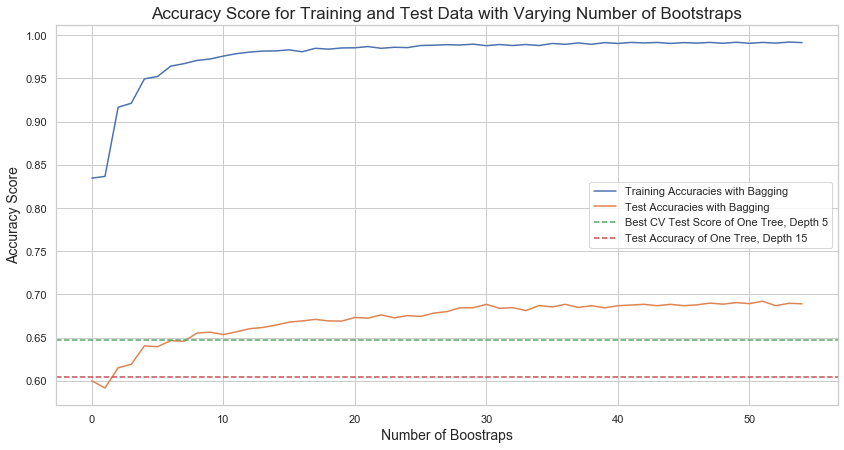

In [25]:
plt.figure(figsize = (14, 7))
plt.plot(trainBootstraps, label = 'Training Accuracies with Bagging')
plt.plot(testBootstraps, label = 'Test Accuracies with Bagging')
plt.axhline(best_cv_tree_test_score, label = 'Best CV Test Score of One Tree, Depth 5', color = 'g', linestyle = 'dashed')
# using the tree depth from 2.1 and the trainBootstraps array 
plt.axhline(OneTreeScore15, label = 'Test Accuracy of One Tree, Depth 15', color = 'r', linestyle = 'dashed')
plt.legend()
plt.xlabel('Number of Boostraps', fontsize = 14)
plt.ylabel('Accuracy Score', fontsize = 14)
plt.title('Accuracy Score for Training and Test Data with Varying Number of Bootstraps', fontsize = 17);

In [26]:
### 2.4 Check that you have the requested function
assert 'running_predictions' in globals(), f"Function 'running_predictions()' does not exist!"

**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single `tree_depth` tree. Explain the differences you see.


With bagging, the test set accuracy starts off (i.e. with very few bootstraps) around the same as the test accuracy of a single tree of depth 15, which makes sense since they're basically the same model at that point. However, as we increase the number of bootstraps in our bagging algorithm, the bagging test accuracy quickly surpasses the test accuracy of the single tree of depth 15.  This is because the single tree of depth 15 is overfit to the training data, whereas bagging fixes this problem by sampling the data and making models on the sample data, decreasing the variance. Bagging thus enables us to maintain the complexity of a deeper tree while not overfitting. This complexity is what enables bagging to surpass the depth-5 simple tree as well (at slightly less than 10 bootstraps), since the depth-5 model is not complex enough. 

**2.6** Bagging and limiting tree depth both affect how much the model overfits. Compare and contrast these two approaches. Your answer should refer to your graph in 2.4 and may duplicate something you said in your answer to 1.5.


Limiting tree depth and bagging are both ways to prevent a model from overfitting, however they do so in different ways. Limiting the tree depth simply makes the model less complex by making it less fit to the training itself, whereas bagging allows us to maintain a complex model yet decrease the variance by bootstrapping. This can be clearly seen in the graph above. Limiting tree depth from 15 to 5 significantly increases our accuracy, as we see that the green line representing a depth of 5 is approximately .65 and the red line representing a depth of 15 is only around .60. However, bagging is superior to simply limiting tree depth because it allows to maintain a more complex model without overfitting. Thus the bagging algorith surpasses the test accuracy for a tree depth of 5 eventually, once we take enough bootstraps to adequately reduce the variance of the model. In this case, it wasn't until around 8 bootstraps that the bagging algorithm performed better on the test set than the limited-tree-depth model.

**2.7**: In what ways might our bagging classifier be overfitting the data? In what ways might it be underfitting?

**Hints**
- Use `resample` from sklearn to easily bootstrap the x and y data.
- use `np.mean` to easily test for majority. If a majority of models vote 1, what does that imply about the mean?

Our bagging classifier might be overfitting the data because it might not reduce the variance enough to compensate for the fact that we are using a deep model with a depth of 15. On the other hadn, if the model itself isn't deep enough, then bagging will not address that problem at all because bagging does not help reduce bias in the model itself.

<div class='exercise'> <b> Question 3 [20 pts]: Random Forests </b> </div>
Random Forests are closely related to the bagging model we built by hand in question 2. In this question we compare our by-hand results with the results of using `RandomForestClassifier` directly.






**3.1**  Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees that you used in Question 2.2. Use number of features to consider when looking for the best split to be the `sqrt(total_number of features`. Evaluate its accuracy on the test set and assign it to a variable name `random_forest_test_score`.

**3.2** Among all of the decision trees you fit in the bagging process, how many times is each feature used as the top/first node? How about for each tree in the random forest you just fit? What about the process of training the Random Forest causes this difference? What implication does this observation have on the accuracy of bagging vs Random Forest?
Assign this to two pandas Series called `top_predictors_bagging` and `top_predictors_rf` and give them an example] 

**Hint**: A decision tree's top feature is stored in `model.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.


**3.3**: Make a pandas table of the training and test accuracy for the following models and name it `results_df`:

- Single tree with best depth chosen by cross-validation (from Question 1)
- A single overfit tree trained on all data (from Question 2, using the depth you chose there)
- Bagging 55 such trees (from Question 2)
- A Random Forest of 55 such trees (from Question 3.1)

(see below for the expected structure)  

(This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.)

What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance trade-off.

## Answers

**3.1**  Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees that you used in Question 2.2. Use number of features to consider when looking for the best split to be the `sqrt(total_number of features`. Evaluate its accuracy on the test set and assign it to a variable name `random_forest_test_score`.


</span></div><div class='alert alert-block alert-danger'><b>WARNING!:</b><span style = 'color:black'> Do not delete any of the `### cs109Test() ###` comment lines!</span></div></div>

In [27]:
### cs109test(test_3.1) ### 
# your code here
#Fit a Random Forest Model

#Training
rfModel = RandomForestClassifier(n_estimators= n_trees, max_features = int(np.sqrt(X_train.shape[1])), max_depth= tree_depth)
rfModel.fit(X_train, y_train)

#Predict
y_pred_test = rfModel.predict(X_test)
y_pred_train = rfModel.predict(X_train)

#Perfromance Evaluation
random_forest_test_score = accuracy_score(y_test, y_pred_test)*100
random_forest_train_score = accuracy_score(y_train, y_pred_train)*100

print("Random Forest: Accuracy, Testing Set :  {:0.2f}%".format(random_forest_test_score))

Random Forest: Accuracy, Testing Set :  69.14%


In [28]:
### 3.1 Check that you have the requested variable
assert 'random_forest_test_score' in globals(), f"Variable 'random_forest_test_score' does not exist!"

**3.2** Among all of the decision trees you fit in the bagging process, how many times is each feature used as the top/first node? How about for each tree in the random forest you just fit? What about the process of training the Random Forest causes this difference? What implication does this observation have on the accuracy of bagging vs Random Forest?
Assign this to two pandas Series called `top_predictors_bagging` and `top_predictors_rf`

**Hint**: A decision tree's top feature is stored in `model.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.



</span></div><div class='alert alert-block alert-danger'><b>WARNING!:</b><span style = 'color:black'> Do not delete any of the `### cs109Test() ###` comment lines!</span></div></div>

In [29]:
### cs109test(test_3.2) ### 
# FOR THE BAGGING
bg = {}
for model in bagging_models:
    if data_train.columns[model.tree_.feature[0]] not in bg.keys():
        bg[data_train.columns[model.tree_.feature[0]]] = 1
    else:
        bg[data_train.columns[model.tree_.feature[0]]] += 1
top_predictors_bagging = pd.Series(bg)
top_predictors_bagging

m_bb    55
dtype: int64

In [30]:
# FOR THE RANDOM FOREST
rf = {}
for mod in rfModel.estimators_:
    if data_train.columns[mod.tree_.feature[0]] not in rf.keys():
        rf[data_train.columns[mod.tree_.feature[0]]] = 1
    else:
        rf[data_train.columns[mod.tree_.feature[0]]] += 1
top_predictors_rf = pd.Series(rf)
top_predictors_rf

jet 2 pt                     3
m_bb                         5
jet 2 eta                    1
m_wwbb                      11
lepton pT                    1
m_jjj                        7
m_wbb                       11
missing energy magnitude     5
jet 2 b-tag                  2
lepton eta                   2
jet 1 pt                     2
jet 3 eta                    1
jet 1 eta                    2
m_jj                         1
m_jlv                        1
dtype: int64

The process of training the Random Forest causes there to be multiple different predictors used as the top node of the tree, because in RF, we choose only a subset of the predictors on which to split the data at each step. This means that for each model, there is only a specific subset of predictors that could potentially be the top predictor. Since the predictor m_bb will not always be in that subset, we will end up with some models in which other predictors will be used in the top node. On the other hand, in the bagging algorithm, all of the predictors are possible options on which to split at every step, and so m_bb always emerges as the most influential predictor, because it is the most influential, and there is no mechanism preventing us from splitting on it every time. This means that the trees in the random forest model are less correlated than those from bagging, meaning that the trees themselves differ more from one to the next in a random forest than they do in bagging. This decreased correlation between trees usually makes RF slightly better than bagging, since it further decreases variance and makes the model less fit to the training data. 

In [31]:
### 3.2 Check that you have the requested variables
for var in ['top_predictors_bagging', 'top_predictors_rf']:
    assert var in globals(), f"Variable '{var}' does not exist!"

**3.3**: Make a pandas table of the training and test accuracy for the following models and name it `results_df`:

- Single tree with best depth chosen by cross-validation (from Question 1)
- A single overfit tree trained on all data (from Question 2, using the depth you chose there)
- Bagging 55 such trees (from Question 2)
- A Random Forest of 55 such trees (from Question 3.1)

(see below for the expected structure)

(This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.)

What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance trade-off.

Fill in the following table.


| classifier | training accuracy | test accuracy |
| --- | --- | --- |
| single tree with best depth chosen by CV | | |
| single depth-X tree | | |
| bagging 55 depth-X trees | | |
| Random Forest of 55 depth-X trees | | |

In [32]:
# your code here
classifiers = ['single tree with best depth chosen by CV (5)', 'single depth-15 tree', 'bagging 55 depth-15 trees', 'Random Forest of 55 depth-15 trees']
allScores = []
allScores.append([best_cv_tree_train_score, best_cv_tree_test_score])
allScores.append([OneTreeScore15Train, OneTreeScore15])
allScores.append([bagging_accuracy_train/100, bagging_accuracy_test/100])
allScores.append([random_forest_train_score/100, random_forest_test_score/100])
results_df = pd.DataFrame(allScores, index = classifiers, columns =  ['Training Accuracy', 'Test Accuracy'])
results_df

,Training Accuracy,Test Accuracy
single tree with best depth chosen by CV (5),0.6812,0.6478
single depth-15 tree,0.9818,0.6040
bagging 55 depth-15 trees,0.9914,0.6892
Random Forest of 55 depth-15 trees,0.9952,0.6914


On the training set, the model of depth 5 performed the worst with an accuracy score of .68. This is because it is not deep enough to properly fit the training data (i.e. it has more bias), unlike the other 3 models which were all of depth 15, and had accuracy scores on the training set between .981 and .995. 
On the test set, the single tree with a depth of 5 performed better than the single tree of depth 15, because it was not overfit to the training data (i.e. had less variance), and so generalized better to the test data. However, the bagging and RF models outperformed both of these single-tree models, because they allowed us to keep a complex model (i.e. low bias) while not overfitting to the training data (i.e. reduced variance as compared to the simple tree of depth-15). Random forests had a slightly better performance than bagging on the test data because it created models which were less correlated, reducing variance. Thus, these relationships make sense in the context of the bias-variance tradeoff, as the random forest optimizes this tradeoff and so has the best score.

In [33]:
### 3.3 Check that you have the requested variable
assert 'results_df' in globals(), "Variable 'results_df' does not exist!"

<div class='exercise'><b> Question 4 [15 pts]: Boosting </div>
In this question we explore a different kind of ensemble method, boosting, where each new model is trained on a dataset weighted towards observations that the current set of models predicts incorrectly. 

We'll focus on the AdaBoost flavor of boosting and examine what happens to the ensemble model's accuracy as the algorithm adds more estimators (iterations) to the ensemble.

**4.1** We'll motivate AdaBoost by noticing patterns in the errors that a single classifier makes. Fit `tree1`, a decision tree with depth 3, to the training data. 
Report the train and test accuracies. For each predictor, make a plot that compares two distributions: the values of that predictor for examples that `tree1` classifies correctly, and the values of that predictor for examples that `tree1` classifies incorrectly. Do you notice any predictors for which the distributions are clearly different?

*Hints*:
- If you have `fig, axs = plt.subplots(...)`, then `axs.ravel()` gives a list of each plot in reading order.
- [`sns.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) takes `ax` and `label` parameters.

**4.2** The following code (see below) attempts to implement a simplified version of boosting using just two classifiers (described below). However, it has both stylistic and functionality flaws. First, imagine that you are a grader for a Data Science class; write a comment for the student who submitted this code. Then, imagine that you're the TF writing the solutions; make an excellent example implementation. Finally, use your corrected code to compare the performance of `tree1` and the boosted algorithm on both the training and test set.

**4.3** Now let's use the sklearn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 800 iterations. Make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

*Hint*: The `staged_score` method provides the accuracy numbers you'll need. You'll need to use `list()` to convert the "generator" it returns into an ordinary list.

**4.4** Repeat the plot above for a base learner with depth of (1, 2, 3, 4). What trends do you see in the training and test accuracy?

(It's okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.)

**4.5** Based on the plot you just made, what combination of base learner depth and number of iterations seems optimal? Why? How does the performance of this model compare with the performance of the ensembles you considered above?

## Answers

**4.1** We'll motivate AdaBoost by noticing patterns in the errors that a single classifier makes. Fit `tree1`, a decision tree with depth 3, to the training data.
Report the train and test accuracies. For each predictor, make a plot that compares two distributions: the values of that predictor for examples that `tree1` classifies correctly, and the values of that predictor for examples that `tree1` classifies incorrectly. Do you notice any predictors for which the distributions are clearly different?

*Hints*:
- If you have `fig, axs = plt.subplots(...)`, then `axs.ravel()` gives a list of each plot in reading order.
- [`sns.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) takes `ax` and `label` parameters.


In [34]:
# your code here
tree1 = DecisionTreeClassifier(max_depth=3)
tree1.fit(X_train, y_train)

#Check Accuracy of tree in train and test set
tree1_train_score = accuracy_score(y_train, tree1.predict(X_train))
tree1_test_score  = accuracy_score(y_test,  tree1.predict(X_test))

print("Tree 1 (depth-3) Accuracy, Training Set: {:.2%}".format(tree1_train_score))
print("Tree 1 (depth-3) Accuracy, Testing Set: {:.2%}".format(tree1_test_score))

Tree 1 (depth-3) Accuracy, Training Set: 64.18%
Tree 1 (depth-3) Accuracy, Testing Set: 64.42%


In [35]:
correctPred = []
incorrectPred = []

for index, (first, second) in enumerate(zip(tree1.predict(X_train), y_train)):
    if first == second:
        correctPred.append(index)
    else:
        incorrectPred.append(index)
correctRows = X_train[correctPred, :]
incorrectRows = X_train[incorrectPred, :]

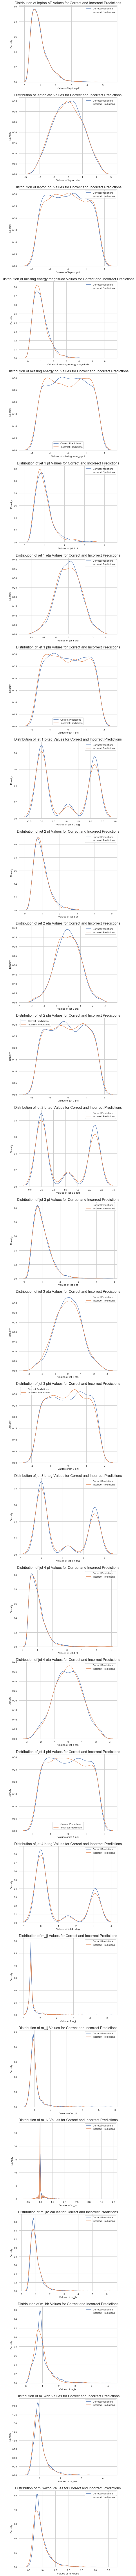

In [36]:
# your code here
fig, ax = plt.subplots(len(X_train[0]), 1, figsize = (8, 110))
plt.subplots_adjust(top = 1.6)
for i in range(len(correctRows[0])):
    sns.kdeplot(correctRows[:, i], ax = ax[i], label = 'Correct Predictions')
    sns.kdeplot(incorrectRows[:, i], ax = ax[i], label = 'Incorrect Predictions')
    ax[i].set_title('Distribution of {} Values for Correct and Incorrect Predictions'.format(data_train.columns[i]), fontsize = 16)
    ax[i].set_xlabel('Values of {}'.format(data_train.columns[i]))
    ax[i].set_ylabel('Density')
    ax[i].legend(loc = 'best')
ax.ravel();

We noticed a few distributions that clearly differed between correct and incorrect predictions in terms of predictor values. First, missing energy phi, jet 1 eta, jet 2 eta, jet 4 eta, and jet 4 phi all have one of the distributions (sometimes correct and sometimes incorrect) that has a dimple in the middle of the distribution during which it dips down in the middle, where the other one seems to be distributed as a typical normal distribution. We also observed that jet 3 phi seemed to be shifted left in the incorrect predictions distribution of predictor values relative to the correct one. The most significant difference between distributions seemed to occur with m_bb, which makes sense given that m_bb seemed to be our top predictor in the problems from earlier. In the m_bb correct predictions distribution, there was much less variability in the distribution relative to the incorrect predictions, which we see through the sharper and taller peak. This was also true, though to a lesser extent, for m_wbb and m_wwbb.

In [37]:
### 4.1 Check that you have the requested variable
assert 'tree1' in globals(), "Variable 'tree1' does not exist!"

**4.2** The following code (see below) attempts to implement a simplified version of boosting using just two classifiers (described below). However, it has both stylistic and functionality flaws. First, imagine that you are a grader for a Data Science class; write a comment for the student who submitted this code. Then, imagine that you're the TF writing the solutions; make an excellent example implementation. Finally, use your corrected code to compare the performance of `tree1` and the boosted algorithm on both the training and test set.


The intended functionality is the following:
1. Fit `tree1`, a decision tree with max depth 3.
2. Construct an array of sample weights. Give a weight of 1 to samples that `tree1` classified correctly, and 2 to samples that `tree1` misclassified.
3. Fit `tree2`, another depth-3 decision tree, using those sample weights.
4. To predict, compute the probabilities that `tree1` and `tree2` each assign to the positive class. Take the average of those two probabilities as the prediction probability.

In [38]:
def boostmeup(X, y):
    tree = DecisionTreeClassifier(max_depth=3)
    tree1 = tree.fit(X, y)
    sample_weight = np.ones(len(X_train))
    q = 0
    for idx in range(len(X_train)):
          if tree1.predict([X_train[idx]]) != y_train[idx]:
             sample_weight[idx] = sample_weight[idx] * 2
             q = q + 1
    # this will give us the inaccuracy score!
    print("tree1 accuracy:", q / len(X_train))
    tree2 = tree.fit(X_train, y_train, sample_weight=sample_weight)
    
# having q count the incorrect predictions is ok, but it would give us the inaccuracy/misclassification rate, so we need to subtract it from 1
# the train and test accuracy score finding algorithms are the same, so it would be better to abstract to a function we call twice
# Train
    q = 0
    for idx in range(len(X_train)):
        t1p = tree1.predict_proba([X_train[idx]])[0][1]
        t2p = tree2.predict_proba([X_train[idx]])[0][1]
        m = (t1p + t2p) / 2
        # this if/else statement can be simplified, we can first classify all predictions as 0 or 1 and then check with y_train
        if m > .5:
            # even within this if statement we can simplify further because we could increment q if y_train[idx] is false
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                # this resets the amount of inaccurate classifiers
                q = 0
    print(q)
    print("Boosted accuracy:", q / len(X_train))

# Test
    q = 0
    for idx in range(len(X_test)):
        t1p = tree1.predict_proba([X_test[idx]])[0][1]
        t2p = tree2.predict_proba([X_test[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            # this should be y_test
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        # this should be y_test that is being checked
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                # this resets the amount of inaccurate classifiers
                q = 0
    print("Boosted accuracy:", q / len(X_test))

boostmeup(X_train, y_train)

tree1 accuracy: 0.3582
4
Boosted accuracy: 0.0008
Boosted accuracy: 0.002


6/10-- Good work! 4 points were removed for an incorrect calculation of accuracy scores and stylistic redundancy. 
We suggest the student a few different improvements:
1. Having q count the incorrect predictions is ok, but it would give us the inaccuracy/misclassification rate, so we need to subtract it from 1
2. The train and test accuracy score finding algorithms are the same, so it would be better to abstract to a function we call twice
3. The if/else statement can be simplified, we can first classify all predictions as 0 or 1 and then check with y_train
4. When you are counting the amount of inaccurate classifications, if the classification is correct, you say q = 0. This resets the amount rather than simply not modifying it.
5. Remember to use y_test rather than y_train when calculating the accuracy of your test set.

In [39]:
# your code here
#helper function to calculate accuracy of boosting model
def average_acc(X, y, tree1, tree2):
    q = 0
    for idx in range(len(X)):
        t1p = tree1.predict_proba([X[idx]])[0][1]
        t2p = tree2.predict_proba([X[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            m = 1
        else:
            m = 0
        if y[idx] != m:
            q += 1
    acc = 1 - (q / len(X))
    return acc

def boostmeup(X, y):
    tree = DecisionTreeClassifier(max_depth=3)
    tree1 = tree.fit(X, y)
    weights = np.ones(len(X_train))
    q = 0
    for idx in range(len(X_train)):
        if tree1.predict([X_train[idx]]) != y_train[idx]:
            weights[idx] = weights[idx] * 2
            q += 1
    tree1acc = 1 - (q / len(X_train))
    
    tree2 = tree.fit(X_train, y_train, sample_weight=weights)
    return(tree1acc, tree1, tree2)

In [40]:
tree1acc, tree1, tree2 = boostmeup(X_train, y_train)
train = average_acc(X_train, y_train, tree1, tree2)
test = average_acc(X_test, y_test, tree1, tree2)
print('Simple tree accuracy is {}'.format(tree1acc))
print('Boosting train accuracy is {}'.format(train))
print('Boosting test accuracy is {}'.format(test))

Simple tree accuracy is 0.6417999999999999
Boosting train accuracy is 0.6134
Boosting test accuracy is 0.6088


In [41]:
### 4.2 Check that you have the requested variables
for var in ['tree1', 'tree2']:
    assert var in globals(), f"Variable '{var}' does not exist!"

**4.3** Now let's use the sklearn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 800 iterations. Make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

*Hint*: The `staged_score` method provides the accuracy numbers you'll need. You'll need to use `list()` to convert the "generator" it returns into an ordinary list.


In [42]:
# code adapted from Section 8
#Fit an Adaboost Model
#Training
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), 
                           n_estimators=800, 
                           learning_rate=0.05)
model.fit(X_train, y_train)

#Predict
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

#Performance Evaluation
acc_boosting_training = accuracy_score(y_train, y_pred_train)*100
acc_boosting_test = accuracy_score(y_test, y_pred_test)*100

print("Ada Boost:\tAccuracy, Training Set \t: {:0.2f}%".format(acc_boosting_training))
print("Ada Boost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_boosting_test))

Ada Boost:	Accuracy, Training Set 	: 90.26%
Ada Boost:	Accuracy, Testing Set 	: 66.68%


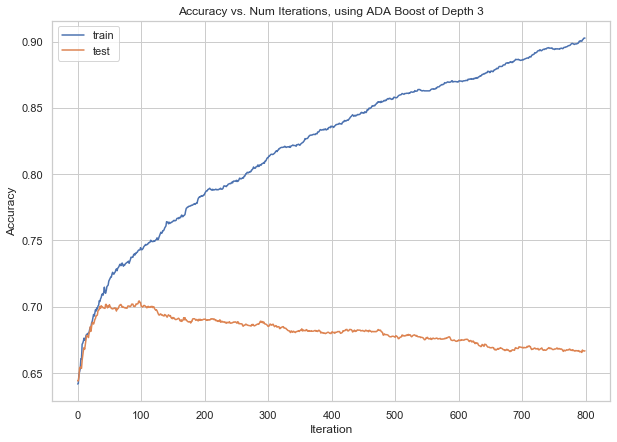

In [43]:
# code adapted from Section 8
#Plot Iteration based score
train_scores = list(model.staged_score(X_train,y_train))
test_scores = list(model.staged_score(X_test, y_test))

plt.figure(figsize=(10,7))
plt.plot(train_scores,label='train')
plt.plot(test_scores,label='test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title("Accuracy vs. Num Iterations, using ADA Boost of Depth 3")
plt.legend();

In [44]:
best_test = np.max(test_scores)
best_test_iter = np.where(test_scores == np.max(test_scores))[0][0]
best_train = train_scores[best_test_iter]
print("Best test score is {}, and it occurs on the {} iteration model.".format(best_test, best_test_iter))
print("Best training score on the {} iteration model is {}.".format(best_test_iter, best_train))

Best test score is 0.7044, and it occurs on the 97 iteration model.
Best training score on the 97 iteration model is 0.7428.


**4.4** Repeat the plot above for a base learner with depth of (1, 2, 3, 4). What trends do you see in the training and test accuracy?

(It's okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.)


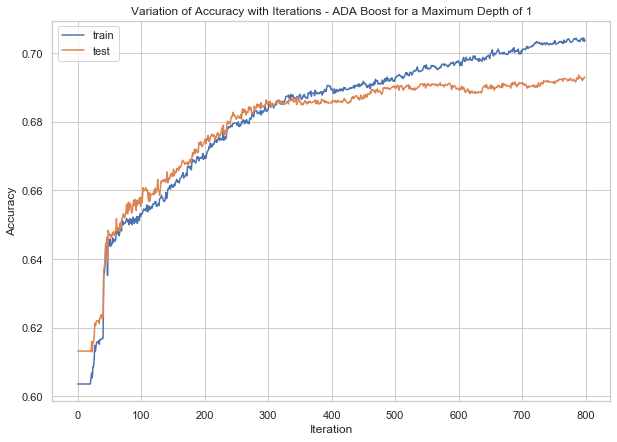

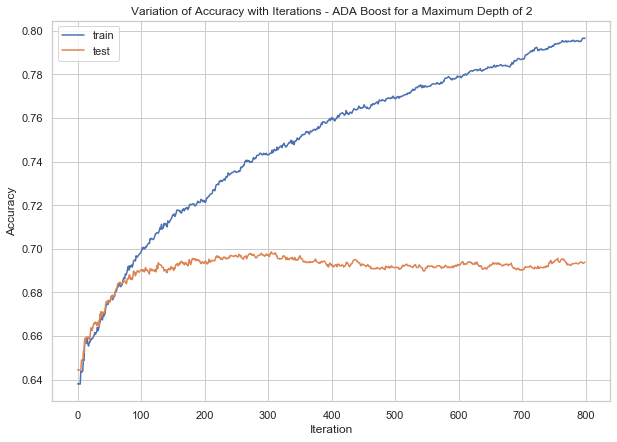

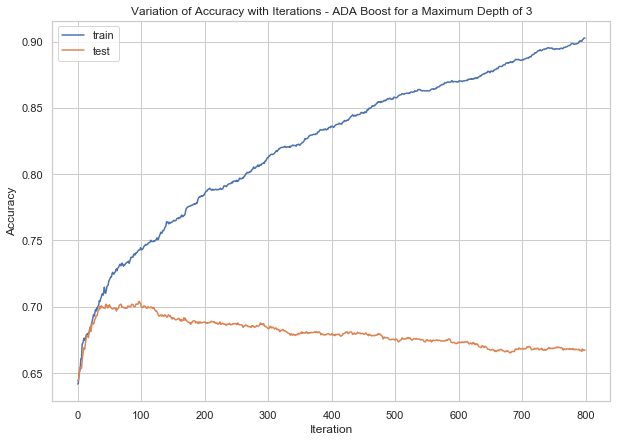

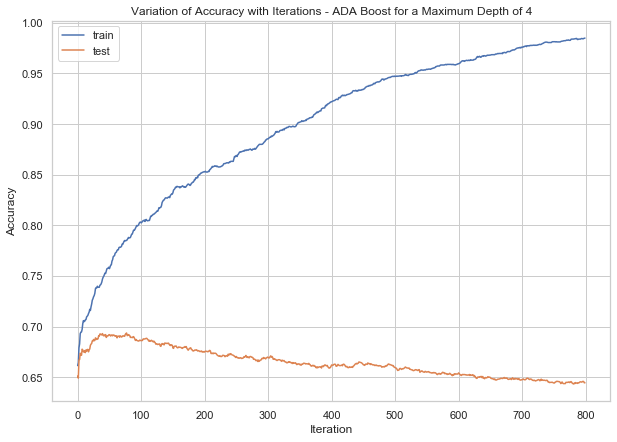

In [45]:
# your code here
# code from Section 8
#Fit an Adaboost Model
#Training
for i in range(1, 5):
    model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=i), 
                               n_estimators=800, 
                               learning_rate=0.05)
    model.fit(X_train, y_train)

    #Plot Iteration based score
    train_scores = list(model.staged_score(X_train,y_train))
    test_scores = list(model.staged_score(X_test, y_test))

    plt.figure(figsize=(10,7))
    plt.plot(train_scores,label='train')
    plt.plot(test_scores,label='test')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title("Variation of Accuracy with Iterations - ADA Boost for a Maximum Depth of {}".format(i))
    plt.legend()
    plt.show();

**4.5** Based on the plot you just made, what combination of base learner depth and number of iterations seems optimal? Why? How does the performance of this model compare with the performance of the ensembles you considered above?

Based on the plot we just made, it would seem that the base learner depth of 3 at 97 iterations seems optimal, as it yields the best test accuracy as compared to all other combinations of tree-depth and num-iterations (this accuracy score is .704, as we show beneath the plot in 4.3)

<div class='exercise'> <b> Question 5 [15 pts]: Understanding </b></div>
This question is an overall test of your knowledge of this homework's material. You may need to refer to lecture notes and other material outside this homework to answer these questions.



**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?


**5.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?

**5.3** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

**5.4** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

**5.5** Which of these techniques can be extended to regression tasks? How?


## Answers

**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?



Boosting and bagging are both mechanisms for optimizing the bias-variance tradeoff in a decision tree. However, they do so through different methods. Bagging works by fitting a complex (deep) decision tree that is overfit and reducing variance by repeating the process on different bootstrapped samples to improve the model. On the other hand, boosting starts with a simple (shallow) decision tree and then decreases bias in this underfit model by increasing the weights on the incorrect predictions and fitting a new model using the updated weights. This process is repeated to increase accuracy by decreasing bias. Both models average in some way the numerous trees used in their algorithm. In sum, both of these methods employ numerous trees to improve accuracy by optimizing the bias-variance tradeoff. Yet, bagging focuses on the variance side of the tradeoff while boosting focuses on the bias side. 

**5.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?


In [46]:
allScores2 = allScores.copy()
classifiers2 = classifiers.copy()

In [47]:
# your code here
allScores2.append([train, test])
allScores2.append([best_train, best_test])
classifiers2.append('Student Boosting from 4.2')
classifiers2.append('Boosting with Optimal Depth and Iterations')
results_df2 = pd.DataFrame(allScores2, index = classifiers2, columns =  ['Training Accuracy', 'Test Accuracy'])
results_df2

,Training Accuracy,Test Accuracy
single tree with best depth chosen by CV (5),0.6812,0.6478
single depth-15 tree,0.9818,0.6040
bagging 55 depth-15 trees,0.9914,0.6892
Random Forest of 55 depth-15 trees,0.9952,0.6914
Student Boosting from 4.2,0.6134,0.6088
Boosting with Optimal Depth and Iterations,0.7428,0.7044


Among the different classifiers shown above, the best performance on the test accuracy came from the boosting with the optimal depth/iteration combination of a depth of 3 and 97 iterations. The test score for this algorithm was .704. We think this may have happened because boosting learns from incorrect classifications by differentially weighting mistaken predictions so that they are learned in future iterations of the tree. The next best performance came from the random forest of 55 trees of depth 15. This model had the highest training accuracy of .9946 and, more importantly, the second highest test accuracy of .6974, barely short of the test accuracy of the optimal boosting tree. We think that the random forest model may have performed best because it reduces the bias-variance tradeoff in a slightly superior way to bagging, since it reduces the correlation between trees by only choosing a certain number of predictors to analyze at every step. This additional step, as compared to the bagging algorithm, may account for the slight advantage in test accuracy we see in RF compared to bagging. We do notice that the bagging algorithm has almost as high of a training and test accuracy, with a training accuracy of .9914 and a test accuracy of .6892. We think that this similarity in scores is do to the fact that bagging, as discussed in 5.1, takes an overfit model and reduces variance. Both of these models (bagging and RF) therefore perform significantly better than the single depth trees and the simple boosting algorithm form 4.2 in which just 2 trees were used.

**5.3** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?


From the plots above, we see that having too many trees in boosting is not an issue if your maximum depth is very small like 1 or 2, because you cannot really overfit the data with such a shallow tree. However, with deeper trees such as depths of 3 and 4, and even more pronouncedly for higher depths, the test accuracy starts to decrease as you have too many trees because you are significantly overfitting your model to the training data. This is because the more times you run the boosting algorithm on the specific mistakes of the training data with a deeper tree, the more you are fitting to the original data, which makes the model less good at generalizing to other data (such as the test set). In the case of bagging, having too many trees is not a problem. Our figure in 2.3 shows that as you increase the number of bootstraps, the test set performance essentially stagnates, but does not decrease. This is because bagging is designed to take overfit models and reduce the variance by sampling from the data and creating models from these new datasets. By bootstrapping more times, I am still just sampling from the same dataset, and so the distribution will not change (same distribution of data as having taken fewer trees, it just might be more clearly defined). This is why the test set accuracy does not decrease as you increase the number of bootstraps. In contrast, it is worse to have too many trees in boosting because it actually does decrease the performance of the model on the test set.

**5.4** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?


Bagging would be better suited to parallelization as compared to boosting. This is because boosting is iterative, which means that each updated model is based off of the previous model, so we cannot allocate this problem to multiple computers working simultaneously. The only thing we could do is have 1 computer start the model and then pass it off to the next computer, but at that point you might as well just have the 1st computer do the whole thing. However, in bagging, all that happens is that we take samples of the original data and then fit models to these new datasets. We could therefore have each computer bootstrap the data separately and make their own models, and then just average all the models across all the computers, thus utilizing all of our computers in parallel.

**5.5** Which of these techniques can be extended to regression tasks? How?

Bagging and boosting can both be extended to regression tasks. In the case of bagging, we could simply take the predictions for all of the different bootstrapped models and average them, yielding a prediction for each sample. In the case of boosting, in which we start with a simple tree and then create new tree weighted more heavily toward the mistakes of the prior tree, the total model is just some combination of all of these trees. We can use the learning rate and error between successive trees to influence how we determine the predictions of the regression.